## This is the svm workbook for ECE C147/C247 Assignment #2

Please follow the notebook linearly to implement a linear support vector machine.

Please print out the workbook entirely when completed.

We thank Serena Yeung & Justin Johnson for permission to use code written for the CS 231n class (cs231n.stanford.edu).  These are the functions in the cs231n folders and includes code to preprocess and show the images.  The classifiers used are based off of code prepared for CS 231n as well.

The goal of this workbook is to give you experience with training an SVM classifier via gradient descent.

## Importing libraries and data setup

In [157]:
import numpy as np # for doing most of our calculations
import matplotlib.pyplot as plt# for plotting
from cs231n.data_utils import load_CIFAR10 # function to load the CIFAR-10 dataset.
import pdb

# Load matplotlib images inline
%matplotlib inline

# These are important for reloading any code you write in external .py files.
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [158]:
# Set the path to the CIFAR-10 data
cifar10_dir = '/Users/lixinyi/Desktop/2020 winter ucla/ece 247/HW2-code/cifar-10-batches-py' # You need to update this line
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


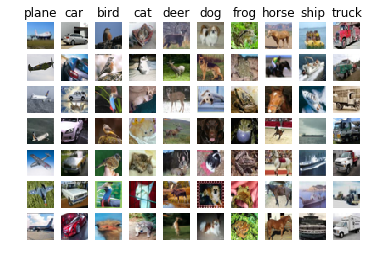

In [159]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [160]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Dev data shape: ', X_dev.shape)
print('Dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)
Dev data shape:  (500, 32, 32, 3)
Dev labels shape:  (500,)


In [161]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


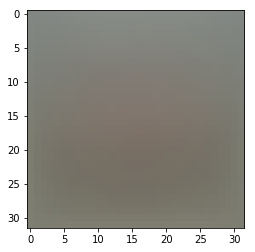

In [162]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [163]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [164]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## Question:

(1) For the SVM, we perform mean-subtraction on the data.
However, for the KNN notebook, we did not.
Why?

## Answer:

(1) Mean-subtraction does not help in KNN because KNN compares distances in between points. Normalizing the data will bring data points closer to each other which makes it hard to compare distances. 

## Training an SVM

The following cells will take you through building an SVM.  You will implement its loss function, then subsequently train it with gradient descent.  Finally, you will choose the learning rate of gradient descent to optimize its classification performance.

In [165]:
from nndl.svm import SVM

In [166]:
# Declare an instance of the SVM class.  
# Weights are initialized to a random value.
# Note, to keep people's initial solutions consistent, we are going to use a random seed.

np.random.seed(1)

num_classes = len(np.unique(y_train))
num_features = X_train.shape[1]

svm = SVM(dims=[num_classes, num_features])

#### SVM loss

In [167]:
## Implement the loss function for in the SVM class(nndl/svm.py), svm.loss()

loss = svm.loss(X_train, y_train)
print('The training set loss is {}.'.format(loss))

# If you implemented the loss correctly, it should be 15569.98

The training set loss is 15569.977915410238.


#### SVM gradient

In [168]:
a = np.array([[1,2,3],[2,3,4]])
print(a)
print(np.sum(a,axis = 0))

[[1 2 3]
 [2 3 4]]
[3 5 7]


In [169]:
## Calculate the gradient of the SVM class.
# For convenience, we'll write one function that computes the loss
#   and gradient together. Please modify svm.loss_and_grad(X, y).
# You may copy and paste your loss code from svm.loss() here, and then
#   use the appropriate intermediate values to calculate the gradient.

loss, grad = svm.loss_and_grad(X_dev,y_dev)

# Compare your gradient to a numerical gradient check. 
# You should see relative gradient errors on the order of 1e-07 or less if you implemented the gradient correctly.
svm.grad_check_sparse(X_dev, y_dev, grad)

(10, 3073)
numerical: -6.190791 analytic: -6.190792, relative error: 2.095246e-08
numerical: -5.930758 analytic: -5.930757, relative error: 3.526434e-08
numerical: -14.358038 analytic: -14.358038, relative error: 1.247602e-09
numerical: 8.220651 analytic: 8.220650, relative error: 4.056009e-08
numerical: -1.002923 analytic: -1.002923, relative error: 2.181863e-07
numerical: -0.073625 analytic: -0.073624, relative error: 3.195629e-06
numerical: 6.517942 analytic: 6.517942, relative error: 1.169909e-08
numerical: -10.297887 analytic: -10.297888, relative error: 4.756163e-08
numerical: -0.366459 analytic: -0.366459, relative error: 5.435021e-08
numerical: -15.354666 analytic: -15.354665, relative error: 9.193814e-09


## A vectorized version of SVM

To speed things up, we will vectorize the loss and gradient calculations.  This will be helpful for stochastic gradient descent.

In [170]:
import time

In [171]:
## Implement svm.fast_loss_and_grad which calculates the loss and gradient
#    WITHOUT using any for loops.  

# Standard loss and gradient
tic = time.time()
loss, grad = svm.loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Normal loss / grad_norm: {} / {} computed in {}s'.format(loss, np.linalg.norm(grad, 'fro'), toc - tic))

tic = time.time()
loss_vectorized, grad_vectorized = svm.fast_loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Vectorized loss / grad: {} / {} computed in {}s'.format(loss_vectorized, np.linalg.norm(grad_vectorized, 'fro'), toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference in loss / grad: {} / {}'.format(loss - loss_vectorized, np.linalg.norm(grad - grad_vectorized)))

# You should notice a speedup with the same output, i.e., differences on the order of 1e-12

(10, 3073)
Normal loss / grad_norm: 15841.11509234872 / 2191.508414906015 computed in 0.09979009628295898s
Vectorized loss / grad: 15841.115092348715 / 2191.508414906015 computed in 0.002624034881591797s
difference in loss / grad: 5.4569682106375694e-12 / 4.250566718035943e-12


## Stochastic gradient descent

We now implement stochastic gradient descent.  This uses the same principles of gradient descent we discussed in class, however, it calculates the gradient by only using examples from a subset of the training set (so each gradient calculation is faster).

iteration 0 / 1500: loss 17524.021088432826
iteration 100 / 1500: loss 4918.92038587432
iteration 200 / 1500: loss 3590.094855628913
iteration 300 / 1500: loss 3048.926659208714
iteration 400 / 1500: loss 2692.1738501794766
iteration 500 / 1500: loss 3238.1175630580997
iteration 600 / 1500: loss 2720.995468172942
iteration 700 / 1500: loss 2735.3997855185285
iteration 800 / 1500: loss 2981.446363242826
iteration 900 / 1500: loss 2177.763042414178
iteration 1000 / 1500: loss 2599.3427810146186
iteration 1100 / 1500: loss 2263.4118265858056
iteration 1200 / 1500: loss 2212.307338363794
iteration 1300 / 1500: loss 2097.90312473708
iteration 1400 / 1500: loss 1665.3492627965813
That took 1.7249500751495361s


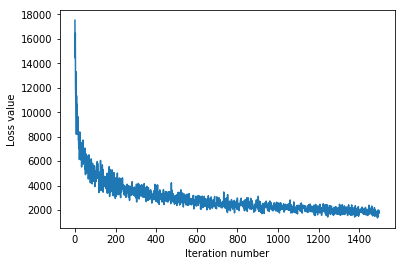

In [194]:
# Implement svm.train() by filling in the code to extract a batch of data
# and perform the gradient step.

tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=5e-4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took {}s'.format(toc - tic))

plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

iteration 0 / 15000: loss 18333.84344869189
iteration 100 / 15000: loss 8654.475692055054
iteration 200 / 15000: loss 6302.678297611809
iteration 300 / 15000: loss 5140.653732200235
iteration 400 / 15000: loss 4556.413348725755
iteration 500 / 15000: loss 4169.585175145447
iteration 600 / 15000: loss 4091.703454461765
iteration 700 / 15000: loss 3803.615535352386
iteration 800 / 15000: loss 3636.199910819129
iteration 900 / 15000: loss 3689.64822863701
iteration 1000 / 15000: loss 3382.3857100494333
iteration 1100 / 15000: loss 4458.682966813431
iteration 1200 / 15000: loss 4136.393363648127
iteration 1300 / 15000: loss 3291.2383876169743
iteration 1400 / 15000: loss 2861.4255454620916
iteration 1500 / 15000: loss 2944.763471180085
iteration 1600 / 15000: loss 3196.835649691237
iteration 1700 / 15000: loss 3459.584166407436
iteration 1800 / 15000: loss 3025.0495905195467
iteration 1900 / 15000: loss 2895.869380508531
iteration 2000 / 15000: loss 3340.424107124086
iteration 2100 / 15000

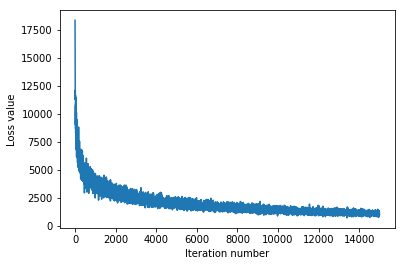

In [201]:

tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-4,
                      num_iters=1500*10, verbose=True)
toc = time.time()
print('That took {}s'.format(toc - tic))

plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### Evaluate the performance of the trained SVM on the validation data.

In [202]:
## Implement svm.predict() and use it to compute the training and testing error.

y_train_pred = svm.predict(X_train)
print(y_train)
print('training accuracy: {}'.format(np.mean(np.equal(y_train,y_train_pred), )))
y_val_pred = svm.predict(X_val)
print('validation accuracy: {}'.format(np.mean(np.equal(y_val, y_val_pred)), ))

[6 9 9 ... 4 9 3]
training accuracy: 0.29351020408163264
validation accuracy: 0.286


## Optimize the SVM

Note, to make things faster and simpler, we won't do k-fold cross-validation, but will only optimize the hyperparameters on the validation dataset (X_val, y_val).

iteration 0 / 7500: loss 23856.14428570748
iteration 500 / 7500: loss 8593.891224453204
iteration 1000 / 7500: loss 8517.98224301735
iteration 1500 / 7500: loss 8795.703507546097
iteration 2000 / 7500: loss 6237.095058816323
iteration 2500 / 7500: loss 9998.283605562878
iteration 3000 / 7500: loss 7229.099374127918
iteration 3500 / 7500: loss 7198.040264063332
iteration 4000 / 7500: loss 8584.114997312834
iteration 4500 / 7500: loss 5735.80529408596
iteration 5000 / 7500: loss 4526.372734535344
iteration 5500 / 7500: loss 5788.501848805611
iteration 6000 / 7500: loss 11054.78274763485
iteration 6500 / 7500: loss 8785.756856527962
iteration 7000 / 7500: loss 8677.530247240935
That took 8.4389009475708s


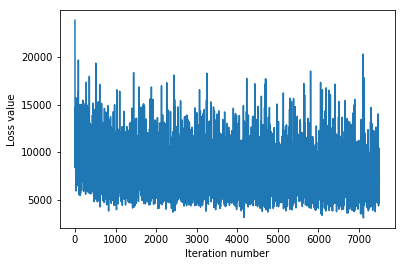

[6 9 9 ... 4 9 3]
training accuracy for learning rate 0.005 is : 0.2920408163265306
validation accuracy for learning rate 0.005 is : 0.283
iteration 0 / 7500: loss 17944.478546017093
iteration 500 / 7500: loss 2121.789364016008
iteration 1000 / 7500: loss 2010.7747293807856
iteration 1500 / 7500: loss 1801.8590929186764
iteration 2000 / 7500: loss 1695.3102911815595
iteration 2500 / 7500: loss 1568.8196055609044
iteration 3000 / 7500: loss 937.8120342462939
iteration 3500 / 7500: loss 1135.6206551509486
iteration 4000 / 7500: loss 918.2656839277489
iteration 4500 / 7500: loss 869.8194724391774
iteration 5000 / 7500: loss 1189.4121743607145
iteration 5500 / 7500: loss 1175.6015991426636
iteration 6000 / 7500: loss 1504.858975949084
iteration 6500 / 7500: loss 772.7471534343166
iteration 7000 / 7500: loss 1209.9391380385507
That took 9.000651836395264s


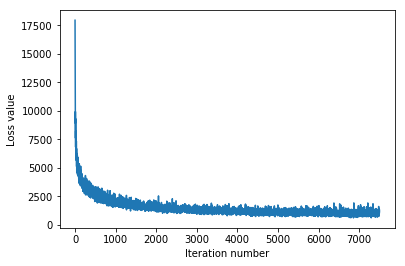

[6 9 9 ... 4 9 3]
training accuracy for learning rate 0.0006 is : 0.33071428571428574
validation accuracy for learning rate 0.0006 is : 0.316
iteration 0 / 7500: loss 18762.799193566003
iteration 500 / 7500: loss 3212.7656374140442
iteration 1000 / 7500: loss 2331.2936815094513
iteration 1500 / 7500: loss 1773.98173420727
iteration 2000 / 7500: loss 2095.544592996394
iteration 2500 / 7500: loss 1314.4302021581034
iteration 3000 / 7500: loss 1446.4407003283936
iteration 3500 / 7500: loss 1321.129063625646
iteration 4000 / 7500: loss 1201.0914238334408
iteration 4500 / 7500: loss 1106.8080288860335
iteration 5000 / 7500: loss 1063.2760939731006
iteration 5500 / 7500: loss 866.1625389738088
iteration 6000 / 7500: loss 873.5063795311688
iteration 6500 / 7500: loss 850.8791628471818
iteration 7000 / 7500: loss 1030.6826194114165
That took 9.118571996688843s


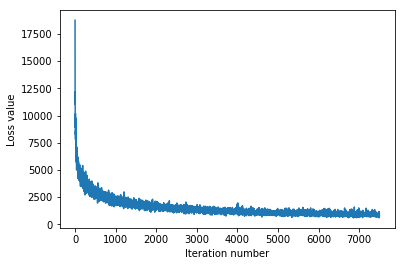

[6 9 9 ... 4 9 3]
training accuracy for learning rate 0.0005 is : 0.30851020408163266
validation accuracy for learning rate 0.0005 is : 0.288
iteration 0 / 7500: loss 18562.681589272277
iteration 500 / 7500: loss 3317.6872674757587
iteration 1000 / 7500: loss 2472.150931919823
iteration 1500 / 7500: loss 1932.1206829224147
iteration 2000 / 7500: loss 1672.34017991148
iteration 2500 / 7500: loss 1497.8498682220938
iteration 3000 / 7500: loss 1237.136165780491
iteration 3500 / 7500: loss 1264.2218435061245
iteration 4000 / 7500: loss 1031.337418871807
iteration 4500 / 7500: loss 1278.4658004628538
iteration 5000 / 7500: loss 1159.1756595126374
iteration 5500 / 7500: loss 970.4390237897314
iteration 6000 / 7500: loss 847.9253184398897
iteration 6500 / 7500: loss 926.4653229251702
iteration 7000 / 7500: loss 808.4744815297585
That took 9.314958810806274s


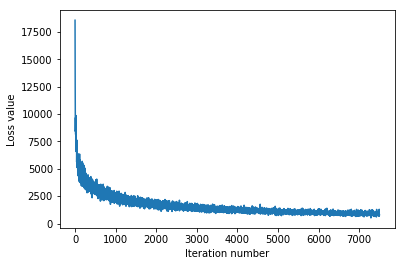

[6 9 9 ... 4 9 3]
training accuracy for learning rate 0.0004 is : 0.3076734693877551
validation accuracy for learning rate 0.0004 is : 0.293
iteration 0 / 7500: loss 19084.20886007788
iteration 500 / 7500: loss 3590.9876107298105
iteration 1000 / 7500: loss 2356.950198684639
iteration 1500 / 7500: loss 2462.7731570750057
iteration 2000 / 7500: loss 2183.371630689215
iteration 2500 / 7500: loss 1979.9175679846626
iteration 3000 / 7500: loss 1319.5122714288177
iteration 3500 / 7500: loss 1361.9178543040516
iteration 4000 / 7500: loss 1324.01803555413
iteration 4500 / 7500: loss 1323.0506224466083
iteration 5000 / 7500: loss 1359.0302414857606
iteration 5500 / 7500: loss 1289.7131617094526
iteration 6000 / 7500: loss 942.4079742011398
iteration 6500 / 7500: loss 930.2574927893997
iteration 7000 / 7500: loss 769.2706404567859
That took 9.223910093307495s


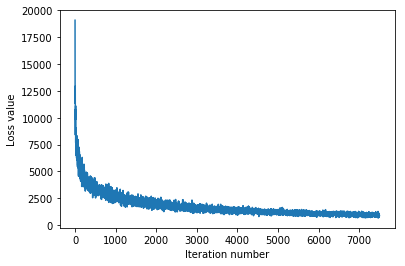

[6 9 9 ... 4 9 3]
training accuracy for learning rate 0.0003 is : 0.303
validation accuracy for learning rate 0.0003 is : 0.276
iteration 0 / 7500: loss 20121.807914687128
iteration 500 / 7500: loss 3982.380857216298
iteration 1000 / 7500: loss 2945.643339960168
iteration 1500 / 7500: loss 2923.950188979848
iteration 2000 / 7500: loss 2524.6383716851255
iteration 2500 / 7500: loss 1814.106585631241
iteration 3000 / 7500: loss 2078.9248098706075
iteration 3500 / 7500: loss 1787.106626050928
iteration 4000 / 7500: loss 1452.0510102430605
iteration 4500 / 7500: loss 1684.0982201707288
iteration 5000 / 7500: loss 1354.5526532526358
iteration 5500 / 7500: loss 1280.3233723066783
iteration 6000 / 7500: loss 1381.8194932231172
iteration 6500 / 7500: loss 1051.0917204974705
iteration 7000 / 7500: loss 1500.2220574404791
That took 9.488584995269775s


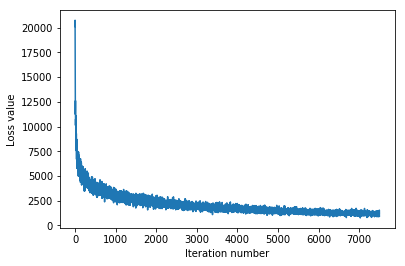

[6 9 9 ... 4 9 3]
training accuracy for learning rate 0.0002 is : 0.29520408163265305
validation accuracy for learning rate 0.0002 is : 0.319
iteration 0 / 7500: loss 18783.51340309055
iteration 500 / 7500: loss 5007.8363373954235
iteration 1000 / 7500: loss 3409.3086087443185
iteration 1500 / 7500: loss 3307.118240976904
iteration 2000 / 7500: loss 2910.737661499231
iteration 2500 / 7500: loss 2754.1824483750984
iteration 3000 / 7500: loss 2498.766866349724
iteration 3500 / 7500: loss 2339.042076383955
iteration 4000 / 7500: loss 2487.0636252986533
iteration 4500 / 7500: loss 2293.2516010845766
iteration 5000 / 7500: loss 1777.8743752265664
iteration 5500 / 7500: loss 1920.9191933207744
iteration 6000 / 7500: loss 1707.1568469774045
iteration 6500 / 7500: loss 1547.9771402096508
iteration 7000 / 7500: loss 1500.9813377225253
That took 9.678108930587769s


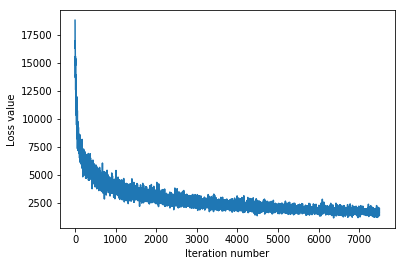

[6 9 9 ... 4 9 3]
training accuracy for learning rate 0.0001 is : 0.29112244897959183
validation accuracy for learning rate 0.0001 is : 0.289
iteration 0 / 7500: loss 16852.44964942459
iteration 500 / 7500: loss 4650.355114688517
iteration 1000 / 7500: loss 4221.688701559118
iteration 1500 / 7500: loss 4368.06545444534
iteration 2000 / 7500: loss 4545.776812508165
iteration 2500 / 7500: loss 3540.722910585644
iteration 3000 / 7500: loss 3523.0744668742104
iteration 3500 / 7500: loss 3184.709580811787
iteration 4000 / 7500: loss 3068.7333180700302
iteration 4500 / 7500: loss 2482.737197526193
iteration 5000 / 7500: loss 3192.512495719697
iteration 5500 / 7500: loss 2685.064637800513
iteration 6000 / 7500: loss 2456.899857498125
iteration 6500 / 7500: loss 2604.1220212038083
iteration 7000 / 7500: loss 2664.8741206604545
That took 10.174451112747192s


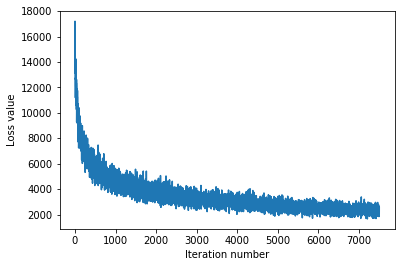

[6 9 9 ... 4 9 3]
training accuracy for learning rate 5e-05 is : 0.28079591836734696
validation accuracy for learning rate 5e-05 is : 0.272
iteration 0 / 7500: loss 19610.018246857027
iteration 500 / 7500: loss 9203.18506433404
iteration 1000 / 7500: loss 7640.4214598602775
iteration 1500 / 7500: loss 6549.296588394524
iteration 2000 / 7500: loss 5793.473971052282
iteration 2500 / 7500: loss 5127.304362509873
iteration 3000 / 7500: loss 5725.620208225759
iteration 3500 / 7500: loss 5896.293167509592
iteration 4000 / 7500: loss 4714.239472674951
iteration 4500 / 7500: loss 4944.584877732597
iteration 5000 / 7500: loss 5229.359391763186
iteration 5500 / 7500: loss 5532.464828954322
iteration 6000 / 7500: loss 5086.729816574554
iteration 6500 / 7500: loss 4455.894580133577
iteration 7000 / 7500: loss 4521.536751620414
That took 9.894176959991455s


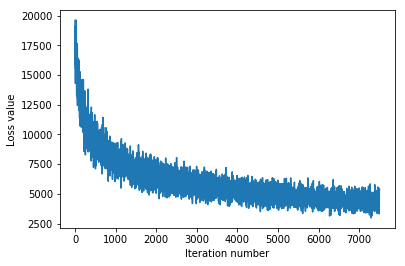

[6 9 9 ... 4 9 3]
training accuracy for learning rate 1e-05 is : 0.24491836734693878
validation accuracy for learning rate 1e-05 is : 0.245
iteration 0 / 7500: loss 16473.86825830593
iteration 500 / 7500: loss 11471.25488657544
iteration 1000 / 7500: loss 9829.758388539109
iteration 1500 / 7500: loss 7694.833989536228
iteration 2000 / 7500: loss 6415.314574088111
iteration 2500 / 7500: loss 7098.624543297612
iteration 3000 / 7500: loss 6096.325178554154
iteration 3500 / 7500: loss 7224.031588185499
iteration 4000 / 7500: loss 6978.72227178046
iteration 4500 / 7500: loss 5484.887902285065
iteration 5000 / 7500: loss 5354.569385975028
iteration 5500 / 7500: loss 6266.1998660664885
iteration 6000 / 7500: loss 5785.354371593304
iteration 6500 / 7500: loss 5379.619252941606
iteration 7000 / 7500: loss 4663.818228596152
That took 9.193060159683228s


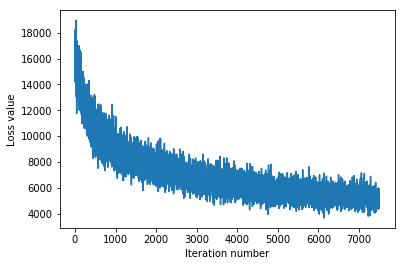

[6 9 9 ... 4 9 3]
training accuracy for learning rate 5e-06 is : 0.23787755102040817
validation accuracy for learning rate 5e-06 is : 0.26
iteration 0 / 7500: loss 15286.826369387727
iteration 500 / 7500: loss 15251.935002368404
iteration 1000 / 7500: loss 15470.275031538475
iteration 1500 / 7500: loss 12464.906896270173
iteration 2000 / 7500: loss 11851.467702142043
iteration 2500 / 7500: loss 12231.676912126084
iteration 3000 / 7500: loss 9539.946848688853
iteration 3500 / 7500: loss 10015.728349532648
iteration 4000 / 7500: loss 9832.830042077861
iteration 4500 / 7500: loss 9380.813228898756
iteration 5000 / 7500: loss 7916.563031194215
iteration 5500 / 7500: loss 9626.387812551051
iteration 6000 / 7500: loss 7997.554534610685
iteration 6500 / 7500: loss 7310.826237446109
iteration 7000 / 7500: loss 8109.382117540471
That took 9.183089971542358s


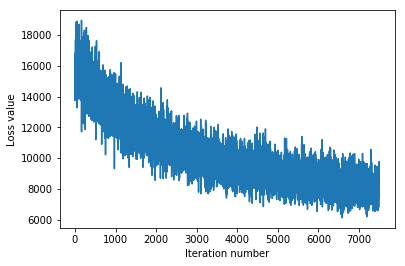

[6 9 9 ... 4 9 3]
training accuracy for learning rate 1e-06 is : 0.17248979591836736
validation accuracy for learning rate 1e-06 is : 0.154
iteration 0 / 7500: loss 15542.658805946934
iteration 500 / 7500: loss 15916.989331922945
iteration 1000 / 7500: loss 15044.257788188486
iteration 1500 / 7500: loss 12462.438019015472
iteration 2000 / 7500: loss 12050.977306391129
iteration 2500 / 7500: loss 12884.173683387227
iteration 3000 / 7500: loss 10766.663833513223
iteration 3500 / 7500: loss 9907.194706310403
iteration 4000 / 7500: loss 9531.107480620378
iteration 4500 / 7500: loss 10749.37987224427
iteration 5000 / 7500: loss 9512.816473562783
iteration 5500 / 7500: loss 8807.463531815565
iteration 6000 / 7500: loss 12044.563849204002
iteration 6500 / 7500: loss 9442.468781725893
iteration 7000 / 7500: loss 10124.890485507067
That took 9.773509979248047s


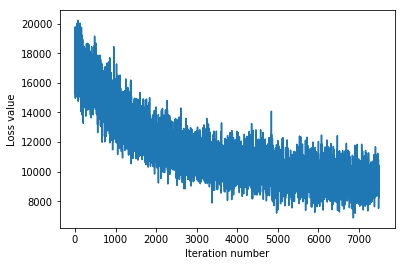

[6 9 9 ... 4 9 3]
training accuracy for learning rate 5e-07 is : 0.15742857142857142
validation accuracy for learning rate 5e-07 is : 0.16
iteration 0 / 7500: loss 17843.149595704497
iteration 500 / 7500: loss 17418.43314180328
iteration 1000 / 7500: loss 18551.43455768045
iteration 1500 / 7500: loss 18585.239167424734
iteration 2000 / 7500: loss 16937.495939924866
iteration 2500 / 7500: loss 17229.439134237313
iteration 3000 / 7500: loss 14094.53943664134
iteration 3500 / 7500: loss 15189.72586517795
iteration 4000 / 7500: loss 15706.591266392425
iteration 4500 / 7500: loss 15441.047027993163
iteration 5000 / 7500: loss 13785.947575763203
iteration 5500 / 7500: loss 15902.143358467114
iteration 6000 / 7500: loss 13415.506883219057
iteration 6500 / 7500: loss 14836.204431571243
iteration 7000 / 7500: loss 12455.064060936496
That took 9.525622844696045s


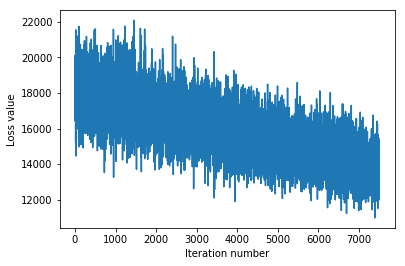

[6 9 9 ... 4 9 3]
training accuracy for learning rate 1e-07 is : 0.1079795918367347
validation accuracy for learning rate 1e-07 is : 0.129


In [208]:
# ================================================================ #
# YOUR CODE HERE:
#   Train the SVM with different learning rates and evaluate on the
#     validation data.
#   Report:
#     - The best learning rate of the ones you tested.  
#     - The best VALIDATION accuracy corresponding to the best VALIDATION error.
#
#   Select the SVM that achieved the best validation error and report
#     its error rate on the test set.
#   Note: You do not need to modify SVM class for this section
# ================================================================ #
tries = np.array([5e-3,6e-4,5e-4,4e-4,3e-4,2e-4,1e-4,5e-5,1e-5,5e-6,1e-6,5e-7,1e-7])
for i in tries:
    tic = time.time()
    loss_hist = svm.train(X_train, y_train, learning_rate=i,
                      num_iters=1500*, verbose=True)
    toc = time.time()
    print('That took {}s'.format(toc - tic))

    plt.plot(loss_hist)
    plt.xlabel('Iteration number')
    plt.ylabel('Loss value')
    plt.show()
    
    y_train_pred = svm.predict(X_train)
    print(y_train)
    print('training accuracy for learning rate',i ,'is : {}'.format(np.mean(np.equal(y_train,y_train_pred), )))
    y_val_pred = svm.predict(X_val)
    print('validation accuracy for learning rate',i ,'is : {}'.format(np.mean(np.equal(y_val, y_val_pred)), ))

# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #


In [209]:
error = 1 - 0.319
print(error)

0.681


The best learning rate is 2e-04. 
The best validation accuracy is 0.319. 
The corresponding validation error is 0.681. 
